We test new masks and inversions for SDP.81 data

In [50]:
#Control time packages
import time
import os
os.environ["OMP_NUM_THREADS"] = "1"


#General packages
import numpy as np
from My_Jampy import JAM
import emcee
import matplotlib.pyplot as plt

from time import perf_counter as clock

#Constants and usefull packages
from astropy.cosmology import Planck15 as cosmo
from astropy.constants import G, M_sun, c
import astropy.units as u

#Autolens Model packages
import autolens as al
import autolens.plot as aplt

#Combined Model package
import CombinedModel

In [2]:
#Useful constants
metre2Mpc = (1*u.m).to(u.Mpc)/u.m           #Constant factor to convert metre to Mpc.
kg2Msun = (1*u.kg/M_sun)*u.solMass/u.kg     #Constant factor to convert kg to Msun

G_Mpc = G*(metre2Mpc)**3/kg2Msun            #Gravitational constant in Mpc³/(Msun s²)
c_Mpc = c*metre2Mpc                         #Speed of light in Mpc/s

#Dataset path
data_folder = "/home/carlos/Documents/GitHub/Master-Degree/SDP81/Autolens/New_models/Data/"

In [3]:
surf_lum, sigma_lum, qobs_lum = np.loadtxt(data_folder+"JAM_Input.txt", unpack=True)       #MGE decomposition
surf_dm, sigma_dm , qobs_dm   = np.loadtxt(data_folder+"SDP81_pseudo-DM.txt", unpack=True) #DM component
norm_psf, sigma_psf           = np.loadtxt(data_folder+"MUSE_Psf_model.txt", unpack=True)  #PSF
ybin, xbin, vrms, erms        = np.loadtxt(data_folder+"pPXF_rot_data.txt", unpack=True)   #Vrms data

In [4]:
muse_pixsize = 0.2                                  #Muse pixel size [arcsec/px]

z_lens   = 0.299                                    #Lens redshifth
z_source = 3.042                                    #Source redshift

#Angular diameter distances
D_l  = cosmo.angular_diameter_distance(z_lens)                   #Lens              
D_s  = cosmo.angular_diameter_distance(z_source)                 #Source
D_ls = cosmo.angular_diameter_distance_z1z2(z_lens, z_source)   #Lens to source

In [12]:
#This quantities are our unknown parameters
#Its values are irrelevant here
inc       = 75                              #Inclination [deg]
mbh       = 1e10                            #Mass of black hole [M_sun]
beta      = np.full_like(surf_lum, 0.3)     #Anisotropy
ml        = 10                              #Mass to light ratio [M_sun/L_sun]
mag_shear = 0.01                            #Shear magnitude
phi_shear = 100.0                           #Shear angle
rho_s     = 1e10                            #dark matter intensity
qdm       = np.full_like(qobs_dm, 0.5)      #dark matter axial ratio
gamma     = 1.0                             #Gamma

shear_comp = al.convert.shear_elliptical_comps_from(magnitude=mag_shear, phi=phi_shear)

In [6]:
# JAMPY MODEL

Jam_model = JAM(ybin=ybin * muse_pixsize, xbin=xbin * muse_pixsize, inc=inc, distance=D_l.value,
                     mbh=mbh, beta=beta, rms=vrms, erms=erms, normpsf=norm_psf, 
                     sigmapsf=sigma_psf * muse_pixsize, pixsize=muse_pixsize)

        #Add Luminosity component
Jam_model.luminosity_component(surf_lum=surf_lum, sigma_lum=sigma_lum,
                                    qobs_lum=qobs_lum, ml=ml)
        #Add DM component
Jam_model.DM_component(surf_dm=rho_s * surf_dm, sigma_dm=sigma_dm, qobs_dm=qdm)

# New Mask with threshold

In [13]:
# PYAUTOLENS MODEL

imaging = al.Imaging.from_fits(
        image_path=f"{data_folder}/ALMA_resampled.fits",
        noise_map_path=f"{data_folder}/ALMA_rms_noise_map.fits",
        psf_path=f"{data_folder}/alma_psf.fits",
        pixel_scales=0.01,
        image_hdu=1, noise_map_hdu=1
    )

mask_custom = al.Mask.from_fits(
        file_path=f"{data_folder}new_mask.fits", hdu=1, pixel_scales=imaging.pixel_scales
    )

masked_imaging = al.MaskedImaging(imaging=imaging, mask=mask_custom)

mass_profile = al.mp.MGE()

        #Components
mass_profile.MGE_comps(z_l=z_lens, z_s=z_source, 
                       surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum, ml=ml,
                       mbh=mbh, surf_dm =rho_s * surf_dm, sigma_dm=sigma_dm, qobs_dm=qdm)

#Lens galaxy
lens_galaxy = al.Galaxy(
    redshift=z_lens,
    mass=mass_profile,
    shear=al.mp.ExternalShear(elliptical_comps=shear_comp)
)

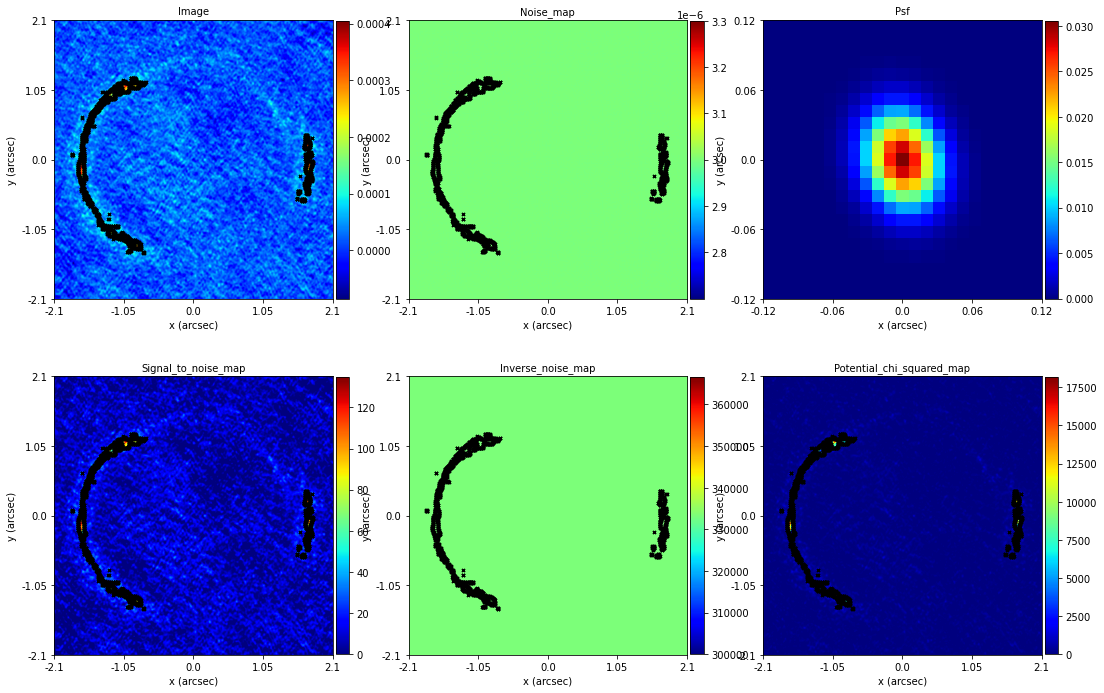

In [14]:
aplt.Imaging.subplot_imaging(
    imaging=imaging, mask=mask_custom, include=aplt.Include(border=False),                         #Plot
)

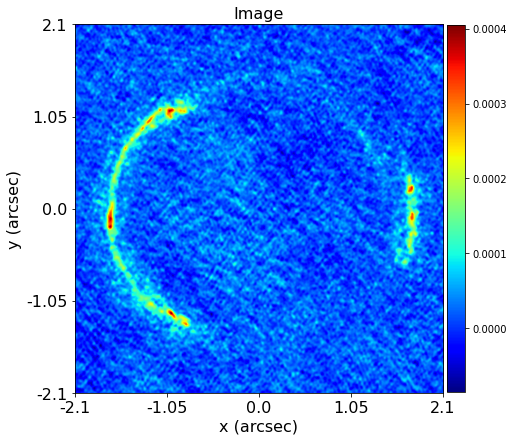

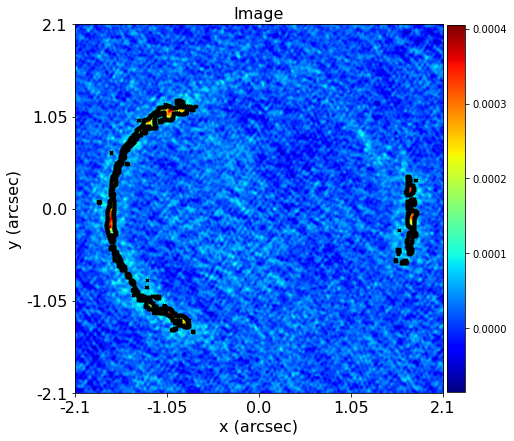

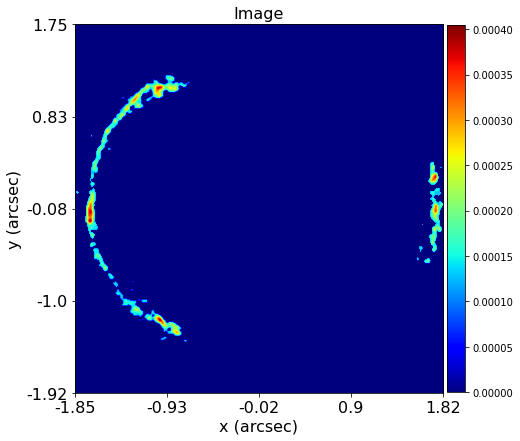

In [80]:
aplt.Imaging.image(imaging)
aplt.Imaging.image(imaging, mask=mask_custom)
aplt.Imaging.image(masked_imaging)

In [18]:
#Now we set the tracer to the source galaxy

start = clock()

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, al.Galaxy(redshift=z_source)])
source_plane_grid = tracer.traced_grids_of_planes_from_grid(grid=masked_imaging.grid)[1]

print("Elapsed time", clock() - start)

Elapsed time 6.565078168001492


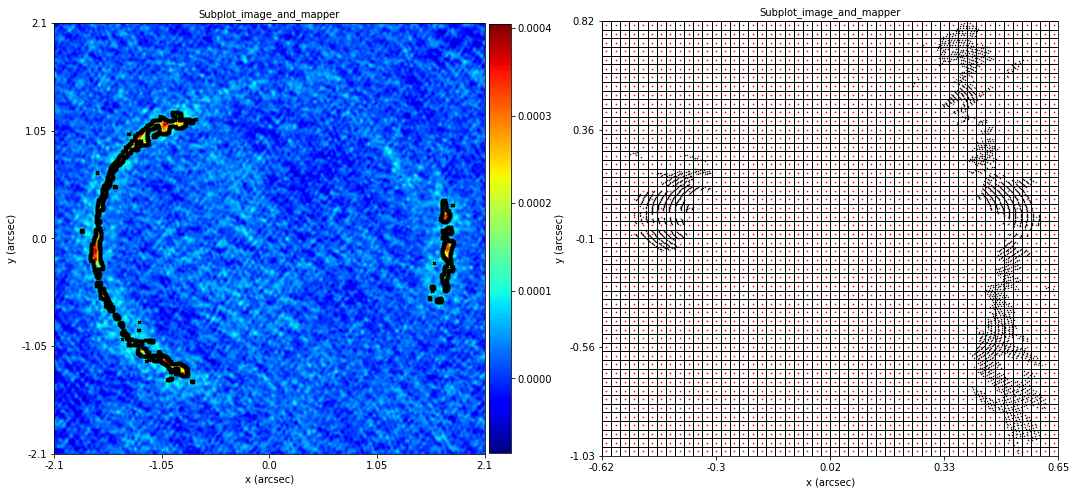

In [19]:
rectangular = al.pix.Rectangular(shape=(50, 50))

mapper = rectangular.mapper_from_grid_and_sparse_grid(grid=source_plane_grid)

aplt.Mapper.subplot_image_and_mapper(
    image=imaging.image,
    mapper=mapper,
    include=aplt.Include(mask=True, inversion_grid=True),
)

In [21]:
inversion = al.Inversion(
    masked_dataset=masked_imaging,
    mapper=mapper,
    regularization=al.reg.Constant(coefficient=4.5),
)

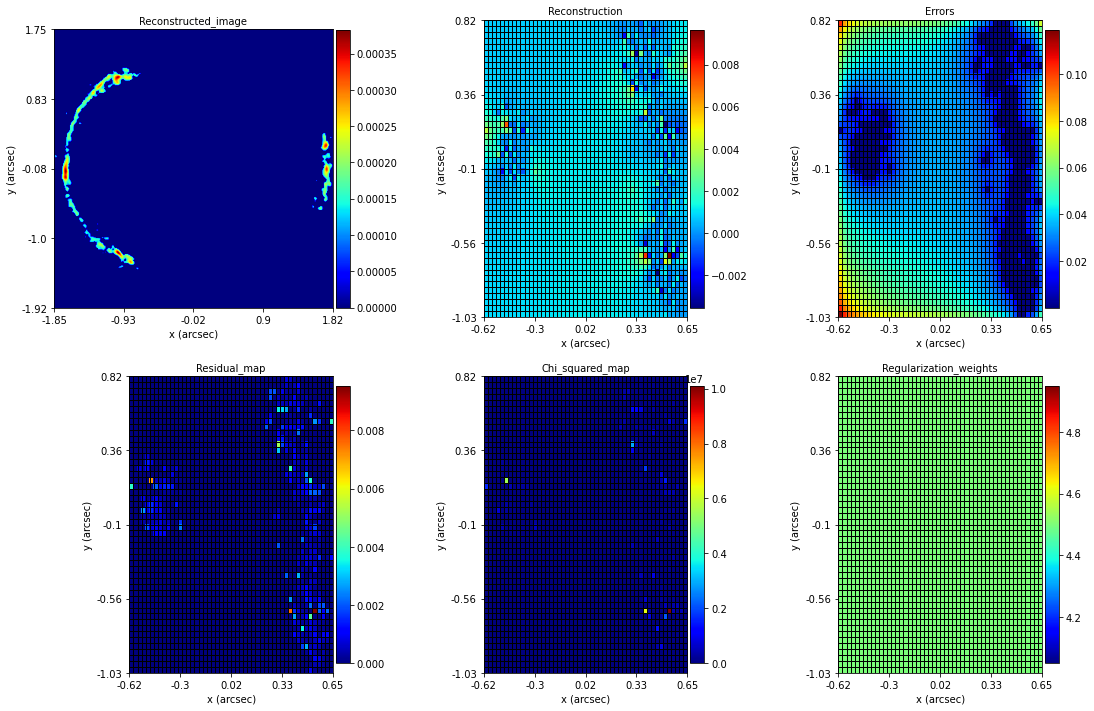

In [22]:
#Plot
aplt.Inversion.subplot_inversion(inversion, include=aplt.Include(mask=False,inversion_border=False,
                                                                 inversion_pixelization_grid=False,))

# New Mask with gui

In [82]:
# PYAUTOLENS MODEL

imaging = al.Imaging.from_fits(
        image_path=f"{data_folder}/ALMA_resampled.fits",
        noise_map_path=f"{data_folder}/ALMA_rms_noise_map.fits",
        psf_path=f"{data_folder}/alma_psf.fits",
        pixel_scales=0.01,
        image_hdu=1, noise_map_hdu=1
    )

mask_custom = al.Mask.from_fits(
        file_path=f"{data_folder}mask2.fits", hdu=0, pixel_scales=imaging.pixel_scales
    )

masked_imaging = al.MaskedImaging(imaging=imaging, mask=mask_custom)

mass_profile = al.mp.MGE()

        #Components
mass_profile.MGE_comps(z_l=z_lens, z_s=z_source, 
                       surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum, ml=ml,
                       mbh=mbh, surf_dm =rho_s * surf_dm, sigma_dm=sigma_dm, qobs_dm=qdm)

#Lens galaxy
lens_galaxy = al.Galaxy(
    redshift=z_lens,
    mass=mass_profile,
    shear=al.mp.ExternalShear(elliptical_comps=shear_comp)
)

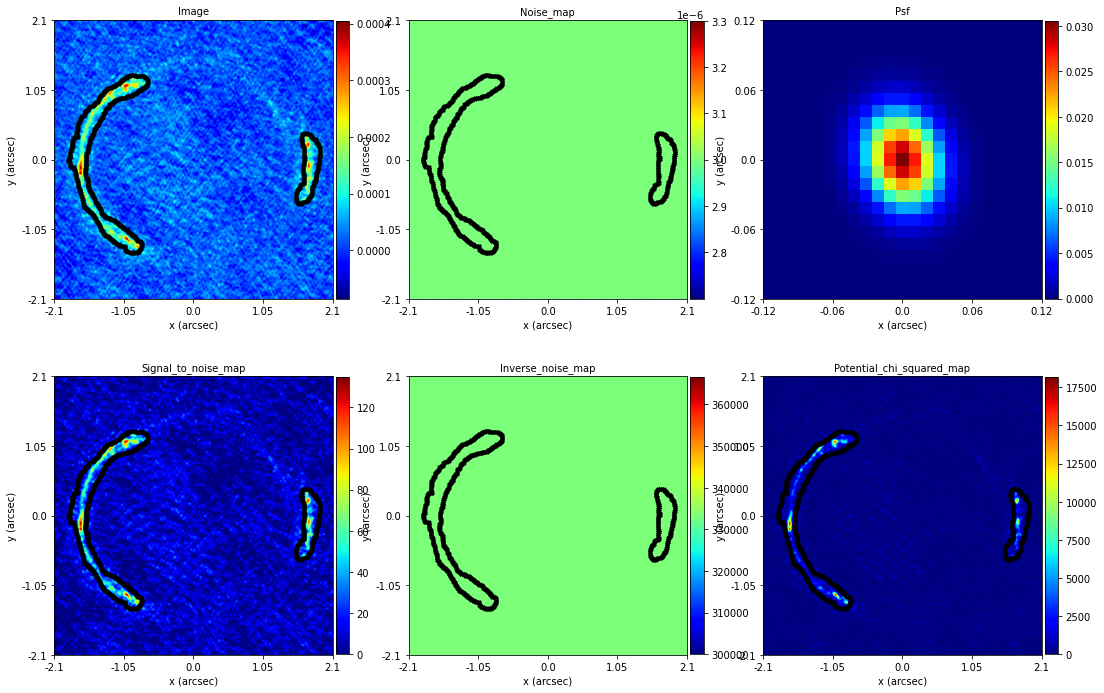

In [83]:
aplt.Imaging.subplot_imaging(
    imaging=imaging, mask=mask_custom, include=aplt.Include(border=False),                         #Plot
)

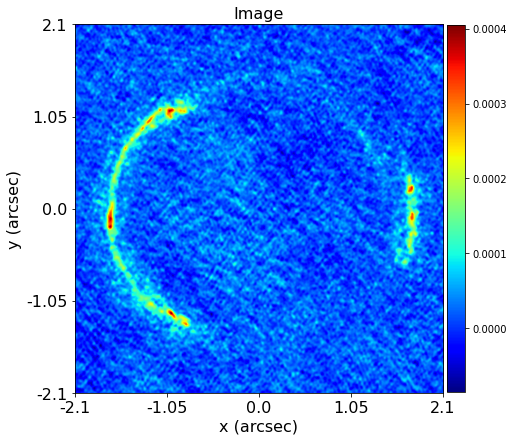

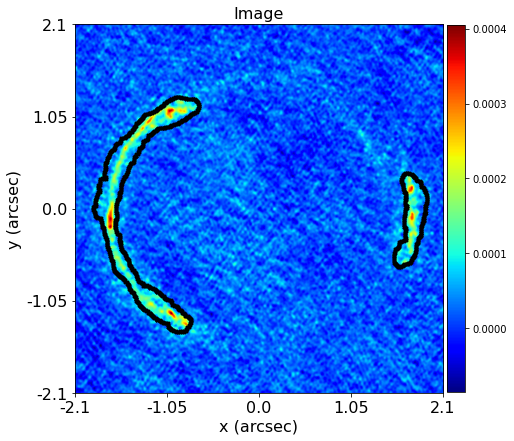

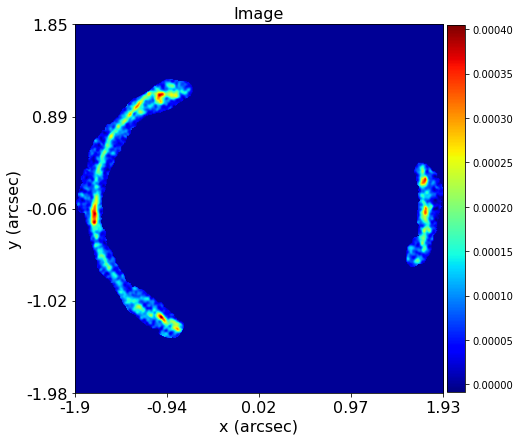

In [84]:
aplt.Imaging.image(imaging)
aplt.Imaging.image(imaging, mask=mask_custom)
aplt.Imaging.image(masked_imaging)

In [85]:
#Now we set the tracer to the source galaxy

start = clock()

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, al.Galaxy(redshift=z_source)])
source_plane_grid = tracer.traced_grids_of_planes_from_grid(grid=masked_imaging.grid)[1]

print("Elapsed time", clock() - start)

Elapsed time 10.336636520005413


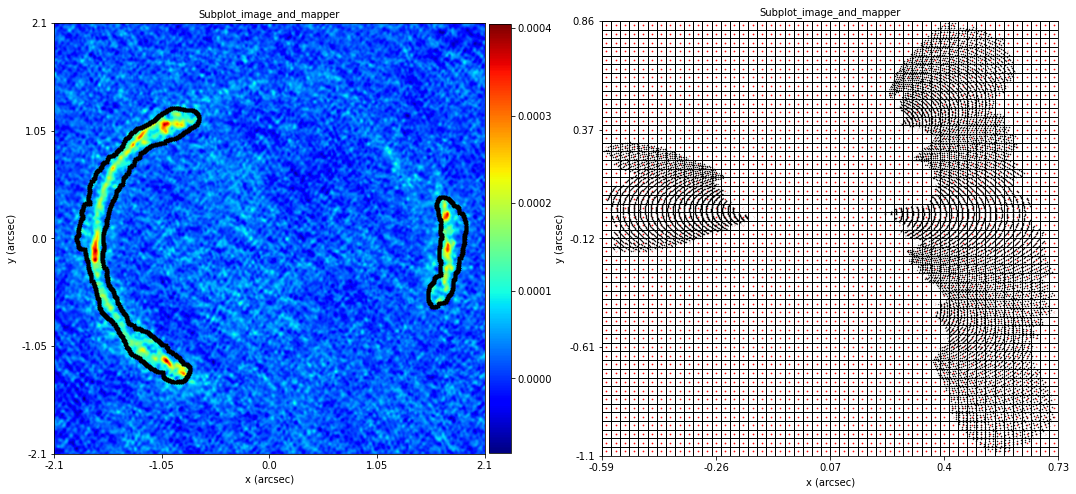

In [86]:
rectangular = al.pix.Rectangular(shape=(50, 50))

mapper = rectangular.mapper_from_grid_and_sparse_grid(grid=source_plane_grid)

aplt.Mapper.subplot_image_and_mapper(
    image=imaging.image,
    mapper=mapper,
    include=aplt.Include(mask=True, inversion_grid=True),
)

In [87]:
inversion = al.Inversion(
    masked_dataset=masked_imaging,
    mapper=mapper,
    regularization=al.reg.Constant(coefficient=4.5),
)

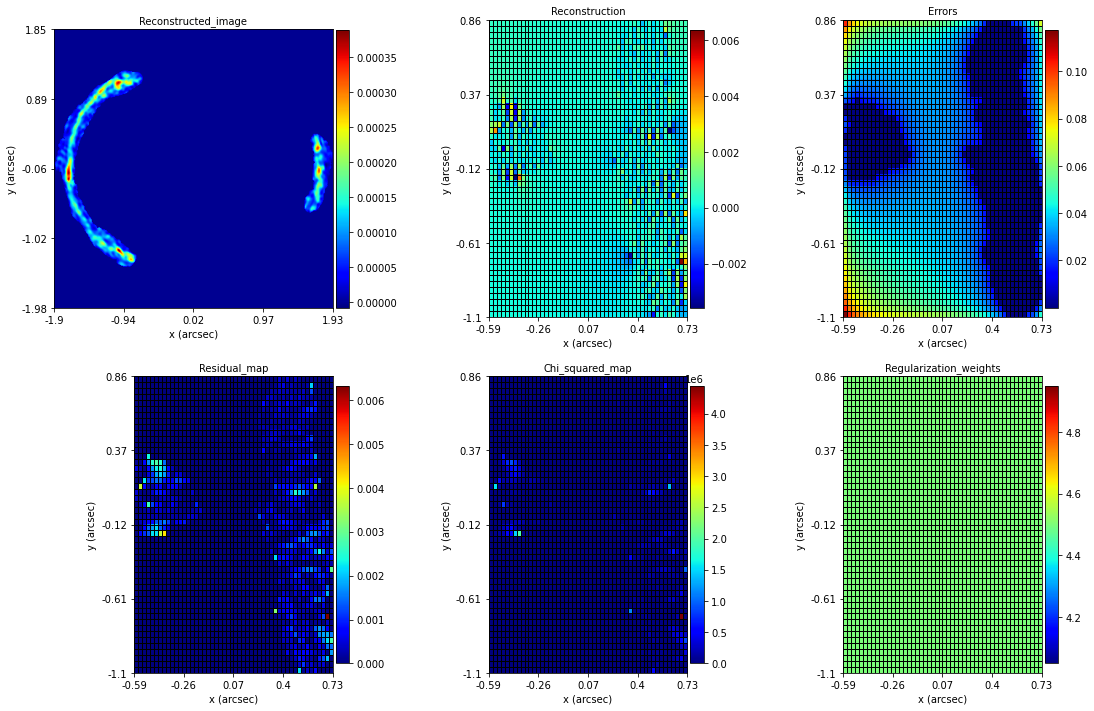

In [91]:
#Plot
aplt.Inversion.subplot_inversion(inversion, include=aplt.Include(mask=False,inversion_border=False,
                                                                 inversion_pixelization_grid=False,))